## <center>Naive Bayes and Bayesian Network <br>
    
<center>Andrea Elliott <br>
Regis University <br>
Due January 30, 2022 </center>

Here I use Naive Bayes Classification to classify SMS messages as spam or not spam ("ham"). 

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#cleaning data
import re
import string
import nltk
from nltk.corpus import stopwords

#wordcloud
from PIL import Image
from wordcloud import WordCloud

#vectorization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Word Counts
from collections import Counter


In [431]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Exploratory Data Analysis

In [432]:
list(df.columns)

['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


The head() function made me suspicious that The 'Unnamed' columns were composed primarily of NaNs. The info() function confirmed this suspicion. I will drop the columns with NaN values. I will also rename the first two columns as the target column and the message column. 

In [434]:
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Now I will graph the value counts of each target type to see how they compare.

In [436]:
counts = df.groupby('target')['target'].agg('count').values
counts

array([4825,  747])

Text(0.5, 1.0, 'Data Distribution by Target')

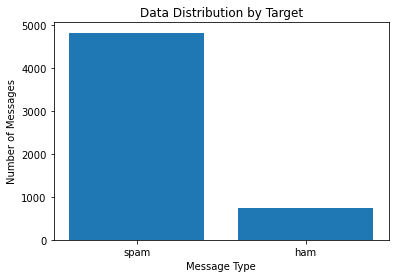

In [437]:
plt.bar(['spam', 'ham'], counts)
plt.xlabel("Message Type")
plt.ylabel("Number of Messages")
plt.title("Data Distribution by Target")

## Cleaning and Transforming the Data

For the first cleaning step, I will use code by Singh (n.d.). The code block will transform text to lowercase, remove text in square brackets, remove links, remove punctuation, and remove words containing numbers.

In [438]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

Now I will add a new column containing the cleaned text.

In [439]:
df['message_clean'] = df['message'].apply(clean_text)
df.head(10)

,target,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling its been weeks now ...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me t...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,as per your request melle melle oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner as a valued network customer you have b...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobile months or more u r entitled t...


At first glance, this looks like the like cleaning was successful. I can see that capital letters and special characters are absent in df['message_clean'].

Next, stop words should be removed. I will use the established list of English stopwords, but I will also add some stopwords that I can see used in this data set that are commonly used text short cuts.

In [440]:
stop_words = stopwords.words('english') 
more_stopwords = ['u', 'im', 'c', 'wif', 'b', 'nah', 'dun', 'ur']
stop_words = stop_words + more_stopwords #combine established stopwords and new ones I selected

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",dont think goes usf lives around though


I will apply a stemming function so that common derivations of the same words are grouped together for the analysis.

In [441]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [442]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head(10)

,target,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",dont think goe usf live around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darl week word back id like fun s...
6,ham,Even my brother is not like to speak with me. ...,even brother like speak treat like aid patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,per request mell mell oru minnaminungint nurun...
8,spam,WINNER!! As a valued network customer you have...,winner valu network custom select receivea å£ ...
9,spam,Had your mobile 11 months or more? U R entitle...,mobil month r entitl updat latest colour mobi...


I can see that the stemming function has been successfully applied. For example, "Joking" in the second row was changed to "joke." I also see some words that have been inappropriately changed. For example, "early" was changed to "earli" and "valued" was changed to "valu."

## Text Analysis

### Text Visualization

In [93]:
mask = np.array(Image.open('book-logo-1.jpg'))

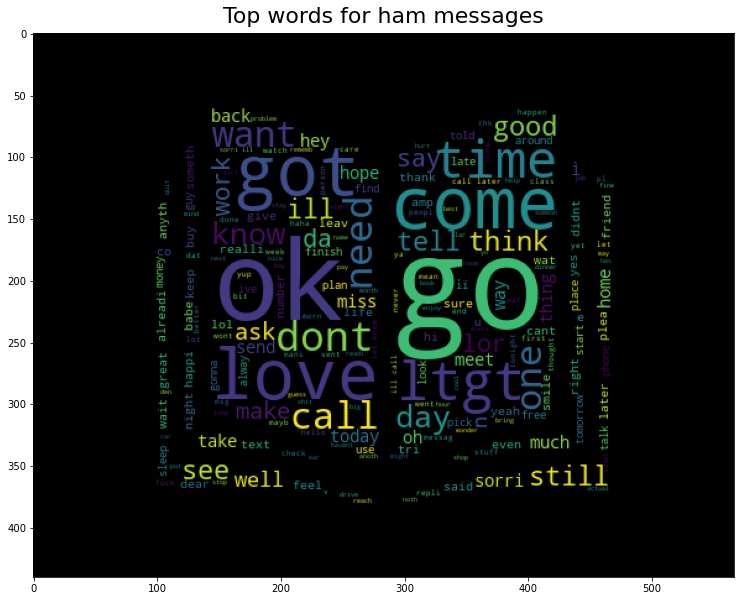

In [131]:
wc = WordCloud(
    background_color = 'black',
    max_words = 200,
    mask = mask,
)

wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))
plt.figure(figsize = (18, 10))
plt.title('Top words for ham messages',
         fontdict = {'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc)
#plt.axis("off")
plt.show()

As I look at this, I saw quite a few words that I don't find particularly useful. 

I returned to my stopwords and removed some more words (e.g., ur, ill, co, oh)

Here is the same code but for spam messages.

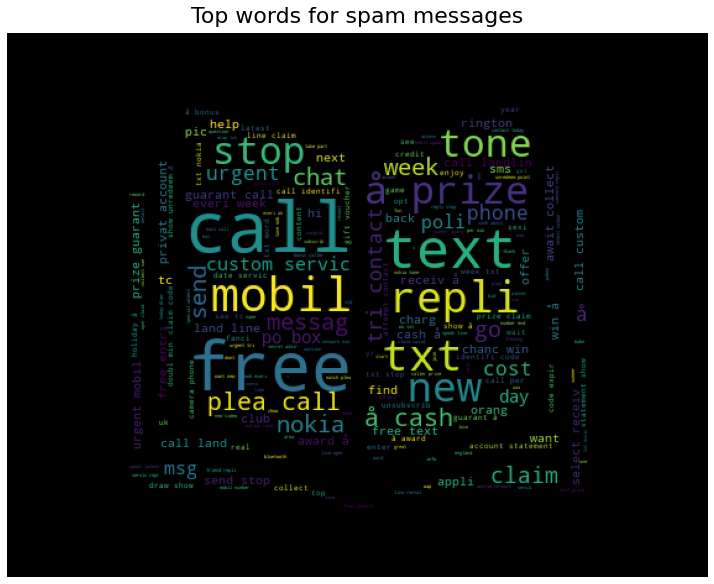

In [97]:
wc = WordCloud(
    background_color='black', 
    max_words=200, 
    mask=mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for spam messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

That's pretty striking. Words like "stop", "urgent", "free", "cash", "new", "prize" stand out to me in the spam word cloud. 

### Text Word Counts

In [236]:
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,dont think goe usf live around though,0


### Vectorization and Document-Term Matrix
I will create a column of target encoded values. Those values along with the lemmas (lists of tokens) will then be used for vectorizaton.

In [444]:
le = LabelEncoder()
le.fit(df['target'])
df['target_encoded'] = le.transform(df['target'])

df.head(10)

,target,message,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",dont think goe usf live around though,0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darl week word back id like fun s...,1
6,ham,Even my brother is not like to speak with me. ...,even brother like speak treat like aid patent,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,per request mell mell oru minnaminungint nurun...,0
8,spam,WINNER!! As a valued network customer you have...,winner valu network custom select receivea å£ ...,1
9,spam,Had your mobile 11 months or more? U R entitle...,mobil month r entitl updat latest colour mobi...,1


The target encoded column indicates which rows are spam and which are ham. <br>

The next lines of code will split the data set into train and test sets.

In [445]:
#define x and y
x = df['message_clean']
y = df['target_encoded']

In [446]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4457 4457
1115 1115


In the code below, I will instantiate and tune the vectorizer.

In [447]:
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

I will use the train and test sets to create a document-term matrix (DTM). The DTM will be used in the next section to run a Naive Bayes analysis of the data.

In [448]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)


In [449]:
x_test_dtm

<1115x5951 sparse matrix of type '<class 'numpy.int64'>'
	with 7894 stored elements in Compressed Sparse Row format>

### Naive Bayes Model

Here I will use the DTMs I calculated above to train and predict a multinomial naive Bayes model.

In [450]:
nb_dtm = MultinomialNB()

#train the model
nb_dtm.fit(x_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

I will use the DTMs to make class and probability predictions.

In [451]:
y_pred_class = nb_dtm.predict(x_test_dtm)
y_pred_prob = nb_dtm.predict_proba(x_test_dtm)[:, 1]

Next we will look at the accuracy of the prediction.


In [452]:
print(metrics.accuracy_score(y_test, y_pred_class))

0.9802690582959641


#### What is the accuracy of the model? 

The accuracy of the model is 0.98. I will use a confusion matrix to help visualize this.

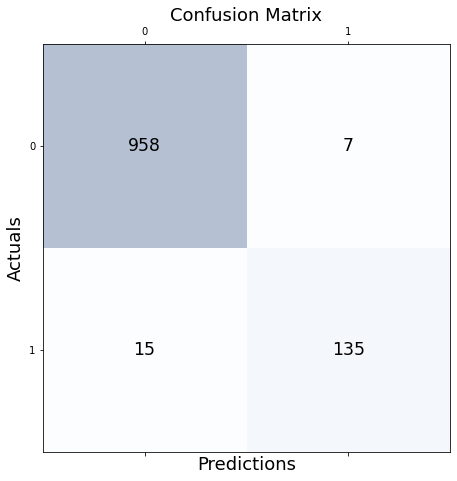

In [453]:
conf_matrix = (metrics.confusion_matrix(y_true = y_test, y_pred = y_pred_class))

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [259]:
conf_matrix

array([[958,   7],
       [ 15, 135]])

### Model Probabilities

I'll calculate the posterior probability of each class.
Here are the steps I'll take.
- dividing into ham and spam. 
- use counter to find the count of each word
- use .mostcommon() to find the top words
- Find the 5 most frequent words in each using counter.
- Use those entries to find the posterior probabilities


In [398]:
#Divide the group into Ham and Spam. Output is all the words
spam = (' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean'])).split()
ham = (' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean'])).split()

#use Counter to count the different entries
spam_count = Counter(spam)
ham_count = Counter(ham)
#print(spam_count)

I will spare the viewer the printout of that last line, but I did confirm that the Counter produced a dictionary with words as the keys and the count as the values.

In [454]:
ham_common = ham_count.most_common(5)
ham_common

[('go', 414), ('get', 360), ('come', 292), ('call', 287), ('ltgt', 276)]

In [455]:
spam_common = spam_count.most_common(6)
spam_common

[('call', 366),
 ('å£', 289),
 ('free', 217),
 ('txt', 150),
 ('text', 138),
 ('mobil', 135)]

I don't know what the second value of spam_count is. It is likely to be something related to some incorrect unicode encoding. <br>

The probability of getting any of these words can be calculated as the count of the word divided by the total number of words.

In [456]:
#add up all the values in spam_count
spam_all = sum(spam_count.values())
ham_all = sum(ham_count.values())
print(spam_all) 
print(ham_all)

9525
36485


In [457]:
type(spam_common)

list

In [459]:
prob_spam = []
for i in spam_common:
    prob_spam.append(round((i[1]/spam_all),2))
    
#round to 4 decimal places because otherwise all of the top values in ham round to 0.01 
#and it's difficult to tell if future code is working
prob_ham = []
for i in ham_common:
    prob_ham.append(round((i[1]/ham_all),4)) 

In [460]:
prob_ham

[0.0113, 0.0099, 0.008, 0.0079, 0.0076]

The next step is to pair these probabilities with their corresponding words.

In [462]:
j = 0
for i in spam_common:
    print("Word " + str(j+1) + " in spam messages is " + str(i[0]) + ", with a posterior probability of " + str(prob_spam[j]))
    j += 1

Word 1 in spam messages is call, with a posterior probability of 0.04
Word 2 in spam messages is å£, with a posterior probability of 0.03
Word 3 in spam messages is free, with a posterior probability of 0.02
Word 4 in spam messages is txt, with a posterior probability of 0.02
Word 5 in spam messages is text, with a posterior probability of 0.01
Word 6 in spam messages is mobil, with a posterior probability of 0.01


In [461]:
j = 0
for i in ham_common:
    print("Word " + str(j+1) + " in ham messages is " + str(i[0]) + ", with a posterior probability of " + str(prob_ham[j]))
    j = j + 1

Word 1 in ham messages is go, with a posterior probability of 0.0113
Word 2 in ham messages is get, with a posterior probability of 0.0099
Word 3 in ham messages is come, with a posterior probability of 0.008
Word 4 in ham messages is call, with a posterior probability of 0.0079
Word 5 in ham messages is ltgt, with a posterior probability of 0.0076


### Improving the model

One potential way to improve the model is to tune the vectorizer to try to improve the score, which I will attempt below. I could also try modeling the data differently, such as with a Gaussian distribution. 

I will try tuning the vectorizer to see if I can improve the accuracy score. 

In [501]:
vect = CountVectorizer(stop_words = 'english', ngram_range = (1,1), min_df = 1, max_df =1.0, max_features = 250)
vect.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=250, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [502]:
x_train_dtm2 = vect.transform(x_train)

In [503]:
nb_dtm2 = MultinomialNB()

#train the model
nb_dtm2.fit(x_train_dtm2, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [506]:
y_pred_class2 = nb_dtm2.predict(x_test_dtm2)

In [507]:
print(metrics.accuracy_score(y_test, y_pred_class2))

0.9551569506726457


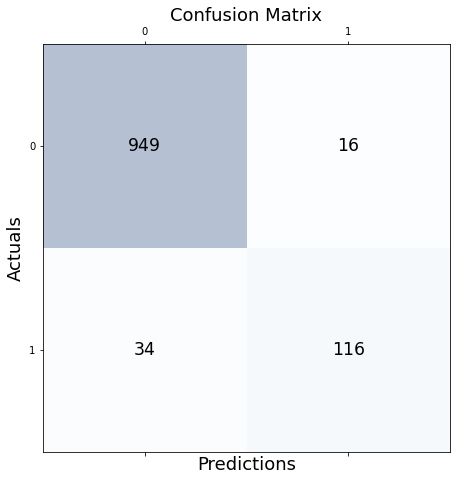

In [508]:
conf_matrix = (metrics.confusion_matrix(y_true = y_test, y_pred = y_pred_class2))

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Despite adjusting some of the inputs in the CountVectorizer(), I was not able to improve upon the 98% accuracy that I initially achieved. 

### Analysis Questions: If the data set is bigger, do you think the accuracy increases? Discuss. <br>
Generally speaking, a larger data set would improve the accuracy of the model. However, plots of sample size vs. accuracy show clear asymptotes. When the size of the training sample is small, the accuracy is likely to be low because there simply is not enough data. As more data is added, the accuracy will generally increase until an asymptote is reached. At that point, adding additional data will not significantly improve the accuracy. For data set falling along the asymptote, errors stay approximately the same. Sometimes adding additional datapoints will reduce model performance due to overfitting (Suau, 2016).

### References <br>

Andreshg. (2021). NLP GloVe, BERT, TF-IDF, lstm...Explained. Kaggle. Retrieved January 25, 2022 from https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained/notebook#4.-Tokens-visualization-%F0%9F%93%8A<br>

Ganesan, K. (n.d.) How to Use Tfidftransformer & Tfidfvectorizer? Kavita Ganesan. Retrieved January 28, 2022 from https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YfSGBVjMJts. <br>

Kumar, A. (2020, September 1). Python - How to Draw Confusion Matrix using Matplotlib. Data Analytics. Retrieved January 27, 2022 from https://vitalflux.com/python-draw-confusion-matrix-matplotlib/. <br>

PFB Staff Writer. (2021, January 30). How to Use Split in Python. Retrieved January 28, 2022 from https://www.pythonforbeginners.com/dictionary/python-split<br>

Reddy, A. (2019, April 30). Counters in Python? Tutorialspoint. Retrieved January 30, 2022 from https://www.tutorialspoint.com/counters-in-python <br>
  
Singh, T. (n.d.) Twitter Sentiment Extraction-Analysis, EDA and model. kaggle. Retrieved January 26, 2022 from https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model/notebook. <br>

Suau, P. (2016, September 16). Does dataset training and test size affect algorithm? Retrieved January 30, 2022 from https://datascience.stackexchange.com/questions/14152/does-dataset-training-and-test-size-affect-algorithm#:~:text=A%20larger%20training%20set%20decreases%20the%20score%20because,an%20increase%20in%20the%20model%27s%20ability%20to%20generalise.
    